This notebook is running on colab

Change paths to run local (cell 5)

In [1]:
!git clone https://github.com/facebookresearch/dinov3.git

Cloning into 'dinov3'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 538 (delta 185), reused 95 (delta 95), pack-reused 241 (from 2)
Receiving objects: 100% (538/538), 9.89 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [2]:
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 35.6 MB/s eta 0:00:00


In [4]:
!pip install pillow matplotlib

import os
from glob import glob
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Metric
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [5]:
DATA_ROOT = '/content/drive/My Drive/DTU/Deep Learning/project'
CLASS_NAME = "leather"
DINOv3_REPO = '/content/dinov3'

DINOV3_WEIGHTS = os.path.join(DATA_ROOT, "dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth")

print("Data root:", DATA_ROOT)
print("Class:", CLASS_NAME)
print("DINOv3 weights:", DINOV3_WEIGHTS)


Data root: /content/drive/My Drive/DTU/Deep Learning/project
Class: leather
DINOv3 weights: /content/drive/My Drive/DTU/Deep Learning/project/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


In [6]:
class MVTecDataset(Dataset):
    def __init__(self, root, class_name, split="train", transform=None):
        super().__init__()
        assert split in ["train", "test"]
        self.root = root
        self.class_name = class_name
        self.split = split
        self.transform = transform

        pattern = os.path.join(root, class_name, split, "*", "*.*")
        paths = sorted(glob(pattern))

        if split == "train":
            paths = [p for p in paths if "good" in Path(p).parts]

        self.image_paths = paths


        self.labels = []
        if split == "test":
            for p in self.image_paths:
                if "good" in Path(p).parts:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            self.labels = [0] * len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = T.ToTensor()(img)

        label = self.labels[idx]
        return img_t, label, img_path


In [7]:
IMG_SIZE = 224

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    ),
])

train_dataset = MVTecDataset(DATA_ROOT, CLASS_NAME, split="train", transform=transform)
test_dataset  = MVTecDataset(DATA_ROOT, CLASS_NAME, split="test",  transform=transform)

print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

Train images: 245
Test images: 124


In [8]:
dinov3_model = torch.hub.load(
    DINOv3_REPO,
    'dinov3_vitb16',
    source='local',
    weights=DINOV3_WEIGHTS,
)
dinov3_model.eval().to(device)

print(dinov3_model)

Downloading: "file:///content/drive/My%20Drive/DTU/Deep%20Learning/project/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


100%|██████████| 327M/327M [00:08<00:00, 42.8MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

In [9]:
"""
tranforming input from shape [B,3,H,W] to [B,D,Hf,Wf]
D is embedding dim and Hf*Wf = number of patch tokens.
"""
class DINOv3FeatureExtractor(nn.Module):
    def __init__(self, dino_model):
        super().__init__()
        self.dino = dino_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feats = self.dino.forward_features(x)
        # keys : ['x_norm_clstoken', 'x_storage_tokens', 'x_norm_patchtokens', 'x_prenorm', 'masks']

        patch_tokens = feats["x_norm_patchtokens"]
        B, N, D = patch_tokens.shape

        side = int(N ** 0.5)
        assert side * side == N, f"Patch count {N} is not a perfect square"
        Hf = Wf = side

        patch_tokens = patch_tokens.view(B, Hf, Wf, D)
        patch_map = patch_tokens.permute(0, 3, 1, 2).contiguous()
        return patch_map

In [10]:
feature_extractor = DINOv3FeatureExtractor(dinov3_model)
feature_extractor.eval().to(device)

DINOv3FeatureExtractor(
  (dino): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (rope_embed): RopePositionEmbedding()
    (blocks): ModuleList(
      (0-11): 12 x SelfAttentionBlock(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SelfAttention(
          (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0,

In [11]:
memory_bank = []

with torch.no_grad():
    for batch_idx, (imgs, labels, paths) in enumerate(train_loader):
        imgs = imgs.to(device)  # [B,3,H,W]
        feats = feature_extractor(imgs)  # [B,D,Hf,Wf]
        B, C, Hf, Wf = feats.shape

        if batch_idx == 0:
            print("Input imgs shape:", imgs.shape)
            print("Feature map shape:", feats.shape)
            print("C, Hf, Wf:", C, Hf, Wf)

        # flatten spatial dims -> (B * Hf * Wf, C)
        feats = feats.view(B, C, -1)
        if batch_idx == 0:
            print("After view(B,C,-1):", feats.shape)# [B,C,N]

        feats = feats.permute(0, 2, 1)# [B,N,C]
        if batch_idx == 0:
            print("After permute to [B,N,C]:", feats.shape)

        feats = feats.reshape(-1, C)# [B*N, C]
        if batch_idx == 0:
            print("After reshape to [B*N,C]:", feats.shape)
            print("First 5 raw patch embeddings (before norm):")
            print(feats[:5])

        feats = F.normalize(feats, dim=1)
        # unit vectors for cosine / L2

        if batch_idx == 0:
            print("First 5 normalized patch embeddings:")
            print(feats[:5])

        memory_bank.append(feats.cpu())

memory_bank = torch.cat(memory_bank, dim=0)  # [N_patches_total, C]
print("Memory bank shape:", memory_bank.shape)   # [N_mem, C]
print("First 5 memory vectors:")
print(memory_bank[:5])

Input imgs shape: torch.Size([8, 3, 224, 224])
Feature map shape: torch.Size([8, 768, 14, 14])
C, Hf, Wf: 768 14 14
After view(B,C,-1): torch.Size([8, 768, 196])
After permute to [B,N,C]: torch.Size([8, 196, 768])
After reshape to [B*N,C]: torch.Size([1568, 768])
First 5 raw patch embeddings (before norm):
tensor([[-0.3913, -0.8740,  0.0556,  ...,  0.7895,  0.0895, -0.5241],
        [-0.3220, -0.9245, -0.0374,  ...,  0.8158,  0.2223, -0.5202],
        [-0.3056, -0.8222,  0.0204,  ...,  0.8846,  0.2078, -0.5104],
        [-0.3597, -0.8075, -0.0220,  ...,  0.7084,  0.1665, -0.5180],
        [-0.3108, -0.7890, -0.0418,  ...,  0.6946,  0.2189, -0.4441]],
       device='cuda:0')
First 5 normalized patch embeddings:
tensor([[-0.0320, -0.0714,  0.0045,  ...,  0.0645,  0.0073, -0.0428],
        [-0.0271, -0.0778, -0.0031,  ...,  0.0687,  0.0187, -0.0438],
        [-0.0256, -0.0689,  0.0017,  ...,  0.0741,  0.0174, -0.0428],
        [-0.0311, -0.0698, -0.0019,  ...,  0.0612,  0.0144, -0.0447],


In [12]:
# first anomalous test image
anomaly_indices = [i for i, lbl in enumerate(test_dataset.labels) if lbl == 1]
if len(anomaly_indices) == 0:
    raise RuntimeError("No anomalous test images found for this class.")

test_idx = anomaly_indices[-3]
print("Using test_idx:", test_idx, "path:", test_dataset.image_paths[test_idx])

# tensor (normalized) and path
img_t, label, img_path = test_dataset[test_idx]
print("Label (1=anomaly):", label)
print("Single test image tensor shape:", img_t.shape)

Using test_idx: 121 path: /content/drive/My Drive/DTU/Deep Learning/project/leather/test/poke/015.png
Label (1=anomaly): 1
Single test image tensor shape: torch.Size([3, 224, 224])


In [36]:
# add batch dimension
img_t_batch = img_t.unsqueeze(0).to(device)
memory_bank_device = memory_bank.to(device)
with torch.no_grad():
    feat = feature_extractor(img_t_batch)
    print("Feature map shape:", feat.shape)

    _, C, Hf, Wf = feat.shape
    feat = feat.view(C, -1).T
    print("Flattened test patches shape:", feat.shape)

    feat = F.normalize(feat, dim=1)
    print("First 5 test patch embeddings:")
    print(feat[:5])

    # pairwise distances between test patches and memory bank
    # result: [N_patches, N_mem]
    dists = torch.cdist(feat, memory_bank_device)
    #torch.cdist is doing euclidean distance L2
    print("Distances tensor shape:", dists.shape)
    print("Distances for first test patch to first 5 normal patches:")
    print(dists[0, :5])

    # # nearest neighbour distance for each patch
    # min_dists, nn_idx = torch.min(dists, dim=1)
    # print("Min distances shape:", min_dists.shape)
    # print("First 10 min distances (patch anomaly scores):")
    # print(min_dists[:10])
    # print("Indices of nearest normal patches for first 10 test patches:")
    # print(nn_idx[:10])

    k = 10
    dists_sorted, _ = torch.sort(dists, dim=1)
    knn_dists = dists_sorted[:, :k]           # [N_patches, k]
    anomaly_score_patch = knn_dists.mean(dim=1)

    # reshape to patch grid
    anomaly_map = anomaly_score_patch.view(1, 1, Hf, Wf)
    print("Anomaly map (low-res) shape:", anomaly_map.shape)
    print("Low-res anomaly map values:")
    print(anomaly_map.view(Hf, Wf))

    # upsample to image size
    anomaly_map = F.interpolate(
        anomaly_map,
        size=(IMG_SIZE, IMG_SIZE),
        mode="bilinear",
        align_corners=False,
    )

    print("Anomaly map (upsampled) shape:", anomaly_map.shape)
    anomaly_map = anomaly_map.squeeze().cpu().numpy()
    print("Anomaly map (upsampled) stats: min =", anomaly_map.min(),
          "max =", anomaly_map.max(),
          "mean =", anomaly_map.mean())

Feature map shape: torch.Size([1, 768, 14, 14])
Flattened test patches shape: torch.Size([196, 768])
First 5 test patch embeddings:
tensor([[-0.0249, -0.0663,  0.0064,  ...,  0.1154, -0.0014, -0.0411],
        [-0.0237, -0.0728, -0.0100,  ...,  0.1061, -0.0139, -0.0405],
        [-0.0275, -0.0709, -0.0022,  ...,  0.0995, -0.0076, -0.0399],
        [-0.0262, -0.0684, -0.0015,  ...,  0.1034, -0.0035, -0.0273],
        [-0.0286, -0.0641, -0.0011,  ...,  0.0986, -0.0159, -0.0439]],
       device='cuda:0')
Distances tensor shape: torch.Size([196, 48020])
Distances for first test patch to first 5 normal patches:
tensor([0.5914, 0.7008, 0.7161, 0.7220, 0.7583], device='cuda:0')
Anomaly map (low-res) shape: torch.Size([1, 1, 14, 14])
Low-res anomaly map values:
tensor([[0.4928, 0.5165, 0.5085, 0.4825, 0.5302, 0.4720, 0.4557, 0.4804, 0.5306,
         0.4766, 0.5153, 0.4952, 0.5034, 0.5272],
        [0.4749, 0.4371, 0.4700, 0.4703, 0.4987, 0.4574, 0.4843, 0.4525, 0.5575,
         0.4724, 0.4770,

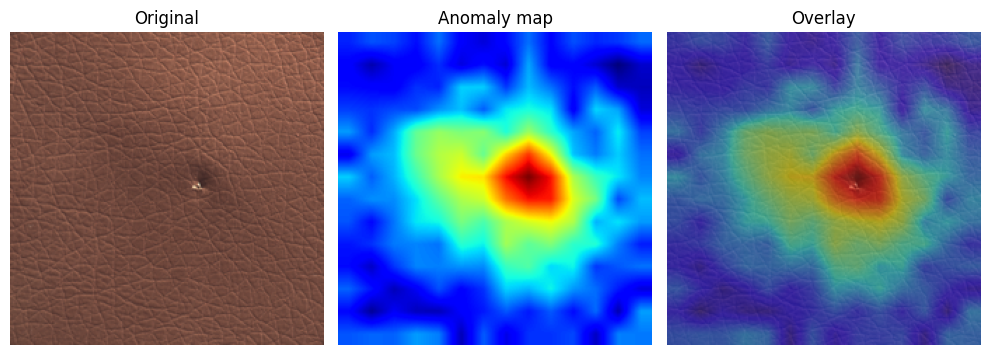

In [37]:
orig_img = Image.open(img_path).convert("RGB")
orig_img = orig_img.resize((IMG_SIZE, IMG_SIZE))
orig_np = np.array(orig_img)

anom_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.axis("off")
plt.imshow(orig_np)

plt.subplot(1, 3, 2)
plt.title("Anomaly map")
plt.axis("off")
plt.imshow(anom_norm, cmap="jet")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.axis("off")
plt.imshow(orig_np)
plt.imshow(anom_norm, cmap="jet", alpha=0.5)

plt.tight_layout()
plt.show()